In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sklearn.model_selection import KFold
from keras import regularizers
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Load data
Xtrain2_b = np.load('Xtrain2_b.npy')
Ytrain2_b = np.load('Ytrain2_b.npy')
Xtest2_b = np.load('Xtest2_b.npy')
# Check dimensions
print(Xtrain2_b.shape)
print(Ytrain2_b.shape)
print(Xtest2_b.shape)

(547, 2304)
(547, 2304)
(196, 2304)


Preprocessing

In [3]:
print("Original unique values:", np.unique(Ytrain2_b))
Ytrain2_b = np.where(Ytrain2_b == 255, 1, Ytrain2_b)
print("Original unique values:", np.unique(Ytrain2_b))

Original unique values: [  0. 255.]
Original unique values: [0. 1.]


In [4]:
# Reshape data
Xtrain2_b = Xtrain2_b.reshape(547,48,48)
Ytrain2_b = Ytrain2_b.reshape(547,48,48)

# Scale data
train_images2_b = (Xtrain2_b).astype('float32')/255.0

Data split

In [5]:
# Split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(train_images2_b, Ytrain2_b, test_size=0.2)

In [6]:
import numpy as np
import cv2  # If you want to use OpenCV for rotation

def augment_images_and_labels(images, labels):
    # Ensure images and labels have the same shape
    assert images.shape == labels.shape
    
    n_samples = images.shape[0]
    augmented_images = np.empty_like(images)
    augmented_labels = np.empty_like(labels)

    for i in range(n_samples):
        # Randomly choose to flip or rotate
        if np.random.rand() > 0.5:  # 50% chance to flip
            if np.random.rand() > 0.5:  # 50% chance to flip horizontally
                augmented_images[i] = np.flip(images[i], axis=1)  # Flip horizontally
                augmented_labels[i] = np.flip(labels[i], axis=1)  # Flip labels similarly
            else:  # Flip vertically
                augmented_images[i] = np.flip(images[i], axis=0)  # Flip vertically
                augmented_labels[i] = np.flip(labels[i], axis=0)  # Flip labels similarly
        else:  # Rotate
            angle = np.random.choice([90, 180, 270])  # Choose a random rotation angle
            # Rotate both images and labels
            augmented_images[i] = cv2.rotate(images[i].squeeze(), cv2.ROTATE_90_CLOCKWISE if angle == 90 else 
                                              cv2.ROTATE_180 if angle == 180 else 
                                              cv2.ROTATE_90_COUNTERCLOCKWISE)
            augmented_labels[i] = cv2.rotate(labels[i].squeeze(), cv2.ROTATE_90_CLOCKWISE if angle == 90 else 
                                               cv2.ROTATE_180 if angle == 180 else 
                                               cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    return augmented_images, augmented_labels

# Example usage:
# images, labels = ...  # Load your images and labels
# augmented_images, augmented_labels = augment_images_and_labels(images, labels)


In [7]:
X_aug, y_aug = augment_images_and_labels(X_train,y_train)

In [8]:
X_train = np.concatenate((X_train,X_aug))
y_train = np.concatenate((y_train,y_aug))

In [9]:
y_train = y_train[..., np.newaxis]
y_val = y_val[..., np.newaxis]

Metric function

In [10]:
def balanced_accuracy(y_true, y_pred):
    # Convert logits to class predictions (0 or 1)
    y_pred = tf.round(tf.clip_by_value(y_pred, 0, 1))  # Round the predictions to get binary values
    
    # Compute confusion matrix components
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))  # True Positives
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))  # True Negatives
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))  # False Positives
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))  # False Negatives

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn + tf.keras.backend.epsilon())  # Avoid division by zero
    specificity = tn / (tn + fp + tf.keras.backend.epsilon())  # Avoid division by zero

    # Balanced Accuracy
    return (sensitivity + specificity) / 2  # Average of sensitivity and specificity

In [20]:
y1 = y_train[0]
y2 = y_train[1]
tf.reduce_sum(tf.cast(y1 * y2, tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=96.0>

Set up model

In [33]:
# Flatten y_train to compute class weights
y_flat = y_train.flatten()

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_flat)

# Create a dictionary for class weights
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Function to create sample weights
#def create_sample_weights(y):
#    sample_weights = np.zeros(y.shape[0])
#    for i in range(y.shape[0]):
#        # Assign the weight based on the class of the sample
#        sample_weights[i] = class_weight_dict[int(y[i].mean() > 0.5)]  # Use mean to determine class
#    return sample_weights

# Create sample weights for the training data
#sample_weights = create_sample_weights(y_train)

print(class_weight_dict)

{0: 0.7006577573896802, 1: 1.7459024921448538}


In [37]:
def weighted_binary_crossentropy(weight_1=1.74590, weight_0=0.70066):
    """
    Custom loss function for binary classification with class weights.
    
    Parameters:
    - weight_1: Weight for class 1.
    - weight_0: Weight for class 0.
    
    Returns:
    - loss function that computes the weighted binary cross-entropy.
    """
    def loss(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        
        # Calculate the weighted binary cross-entropy
        bce = - (weight_1 * y_true * tf.math.log(y_pred) + weight_0 * (1 - y_true) * tf.math.log(1 - y_pred))
        return tf.reduce_mean(bce)

    return loss

In [152]:
def smaller_unet(input_shape):
    inputs = layers.Input(input_shape)
    
    # Encoder path (downsampling)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    drop1 = layers.Dropout(0.2)(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(drop1)  # Output size: 24x24
    
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    drop2 = layers.Dropout(0.2)(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(drop2)  # Output size: 12x12

    #conv2b = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    #conv2b = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2b)
    #drop2 = layers.Dropout(0.5)(conv2)
    #pool3 = layers.MaxPooling2D((2, 2))(conv2b)  # Output size: 12x12

    #conv2bb = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    #conv2bb = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2bb)
    #drop2 = layers.Dropout(0.5)(conv2)
    #pool4 = layers.MaxPooling2D((2, 2))(conv2bb)  # Output size: 12x12
    
    # Bottleneck
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    drop3 = layers.Dropout(0.2)(conv3)
    
    # Decoder path (upsampling)
    #up4aa = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3)
    #merge4aa = layers.concatenate([conv2bb, up4aa], axis=3)
    #conv4aa = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge4aa)
    #conv4aa = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4aa)
    #drop4 = layers.Dropout(0.5)(conv4)
    
    #up4a = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3)
    #merge4a = layers.concatenate([conv2b, up4a], axis=3)
    #conv4a = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge4a)
    #conv4a = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4a)
    #drop4 = layers.Dropout(0.5)(conv4)
    
    up4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(drop3)
    merge4 = layers.concatenate([conv2, up4], axis=3)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.2)(conv4)
    
    up5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(drop4)
    merge5 = layers.concatenate([conv1, up5], axis=3)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    #drop5 = layers.Dropout(0.5)(conv5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv5)
    
    model = Model(inputs, outputs)
    
    return model

input_shape = (48, 48, 1)
model = smaller_unet(input_shape)
model.compile(optimizer='adam', loss=weighted_binary_crossentropy(), metrics=['accuracy', balanced_accuracy])
model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_346 (Conv2D) │ (None, 48, 48,    │        320 │ input_layer_36[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_347 (Conv2D) │ (None, 48, 48,    │      9,248 │ conv2d_346[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 48, 48,    │          0 │ conv2d_347[0][0]  │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_78    │ (None, 24, 24,    │          0 │ dropout_65[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_348 (Conv2D) │ (None, 24, 24,    │     18,496 │ max_pooling2d_78… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_349 (Conv2D) │ (None, 24, 24,    │     36,928 │ conv2d_348[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (None, 24, 24,    │          0 │ conv2d_349[0][0]  │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_79    │ (None, 12, 12,    │          0 │ dropout_66[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_350 (Conv2D) │ (None, 12, 12,    │     73,856 │ max_pooling2d_79… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_351 (Conv2D) │ (None, 12, 12,    │    147,584 │ conv2d_350[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 12, 12,    │          0 │ conv2d_351[0][0]  │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_78 │ (None, 24, 24,    │     32,832 │ dropout_67[0][0]  │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_78      │ (None, 24, 24,    │          0 │ conv2d_349[0][0], │
│ (Concatenate)       │ 128)              │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_352 (Conv2D) │ (None, 24, 24,    │     73,792 │ concatenate_78[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_353 (Conv2D) │ (None, 24, 24,    │     36,928 │ conv2d_352[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_68          │ (None, 24, 24,    │          0 │ conv2d_353[0][0]

 Total params: 465,953 (1.78 MB)

 Trainable params: 465,953 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Train model

In [153]:
reduce_lr = ReduceLROnPlateau(monitor='val_balanced_accuracy', factor=0.5, patience=5, min_lr=1e-9)

early_stopping = EarlyStopping(monitor='val_balanced_accuracy', patience=15, restore_best_weights=True, mode='max')

#callbacks=[reduce_lr, metrics, early_stopping]

history = model.fit(X_train, y_train, batch_size=64,
                         epochs=100,
                         validation_data=(X_val, y_val),
                         callbacks=[reduce_lr, early_stopping],
                         verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - accuracy: 0.4089 - balanced_accuracy: 0.5121 - loss: 0.6916 - val_accuracy: 0.6479 - val_balanced_accuracy: 0.6411 - val_loss: 0.6905 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 310ms/step - accuracy: 0.5471 - balanced_accuracy: 0.6001 - loss: 0.6730 - val_accuracy: 0.6627 - val_balanced_accuracy: 0.6580 - val_loss: 0.6469 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - accuracy: 0.6460 - balanced_accuracy: 0.6459 - loss: 0.6392 - val_accuracy: 0.7416 - val_balanced_accuracy: 0.6517 - val_loss: 0.6428 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - accuracy: 0.6691 - balanced_accuracy: 0.6554 - loss: 0.6227 - val_accuracy: 0.7534 - val_balanced_accuracy: 0.6659 - val_loss: 0.6375 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step - accuracy: 0.6686 - balanced_accuracy: 0.6750 - loss: 0.6083 - val_accuracy: 0.6211 - val_bala

In [154]:
best_val_balanced_accuracy = max(history.history['val_balanced_accuracy'])
print(f"Best Validation Balanced Accuracy: {best_val_balanced_accuracy}")
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_val_accuracy}")

Best Validation Balanced Accuracy: 0.8123985528945923
Best Validation Accuracy: 0.8550110459327698


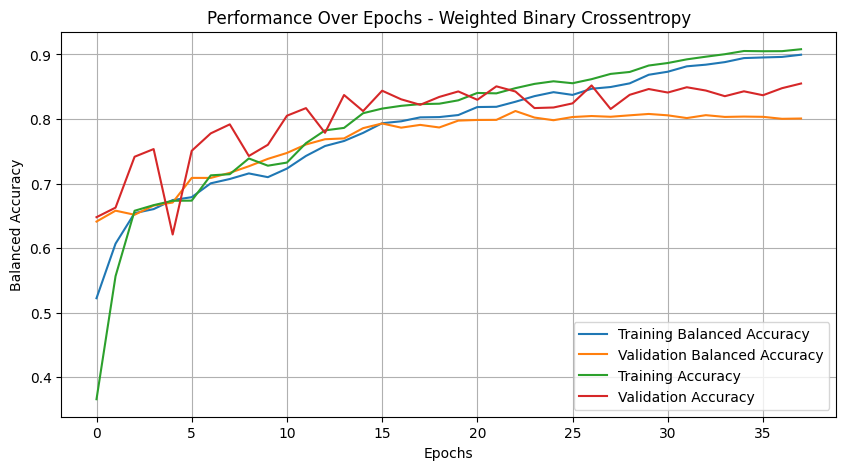

In [155]:
import matplotlib.pyplot as plt

# Extract metrics from history
val_balanced_accuracy = history.history.get('val_balanced_accuracy', [])
train_balanced_accuracy = history.history.get('balanced_accuracy', [])
val_accuracy = history.history.get('val_accuracy', [])
train_accuracy = history.history.get('accuracy', [])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_balanced_accuracy, label='Training Balanced Accuracy')
plt.plot(val_balanced_accuracy, label='Validation Balanced Accuracy')
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Performance Over Epochs - Weighted Binary Crossentropy')
plt.xlabel('Epochs')
plt.ylabel('Balanced Accuracy')
plt.legend()
plt.grid()
plt.show()


Sanity check

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
(547, 48, 48, 1)


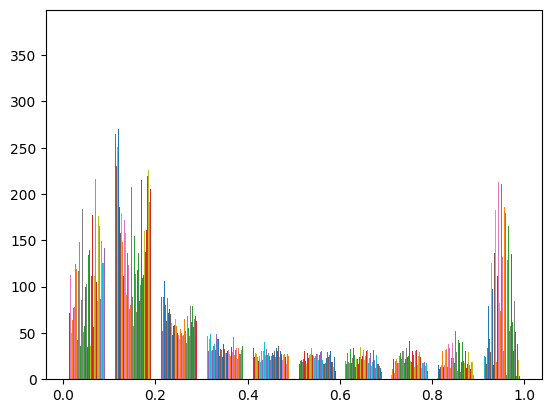

In [212]:
temp = model.predict(train_images2_b)
print(temp.shape)
temp = temp.reshape(547,-1)
plt.figure()
plt.hist(temp)
plt.show()

In [213]:
abs_miss = np.sum(np.abs(np.round(Ytrain2_b.reshape(547,-1)) - np.round(temp)))
print(abs_miss/(547*2304))

0.13965299994921795


Test model

In [209]:
Xtest2_b.shape

(196, 48, 48)

In [210]:
Xtest2_b = Xtest2_b.reshape(196,48,48)

# Scale data
test_images2_b = (Xtest2_b).astype('float32')/255.0

predictions = model.predict(test_images2_b)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [221]:
predictions = predictions.reshape(196,-1)
predictions = np.round(predictions)
print(predictions)
print(np.sum(predictions))
print(predictions.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
131269.0
(196, 2304)


In [222]:
np.save('predictions', predictions)

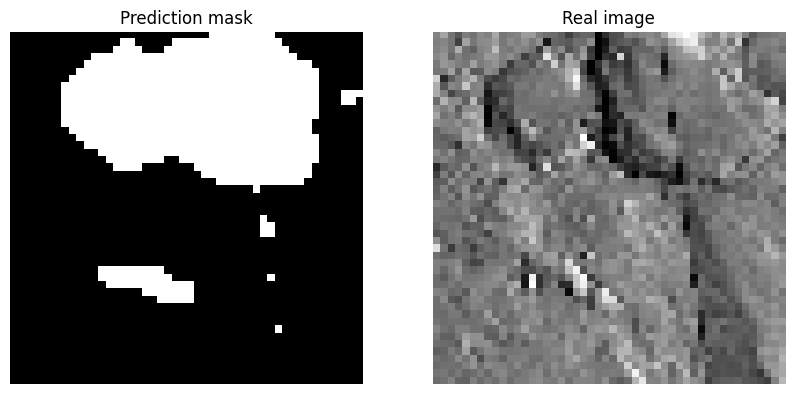

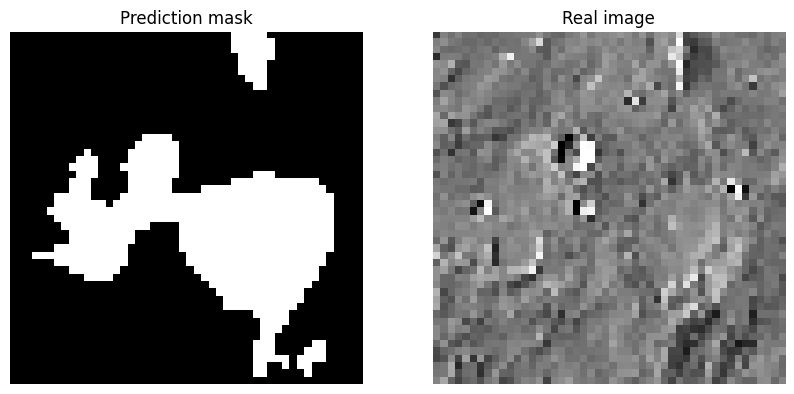

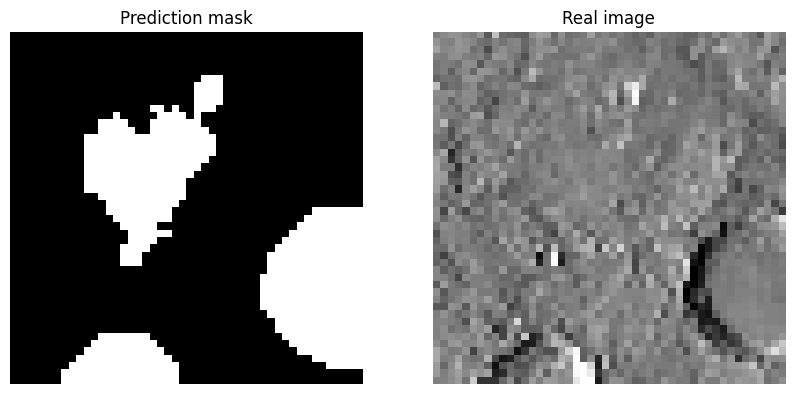

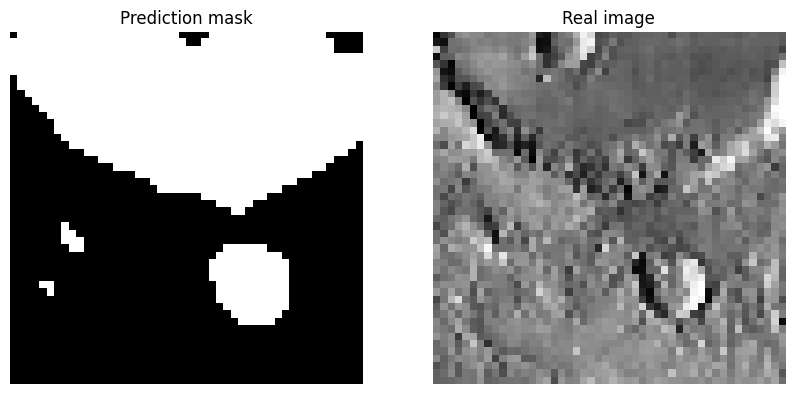

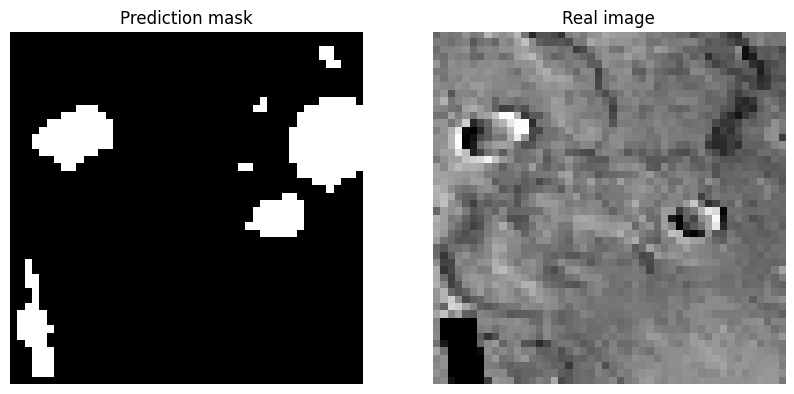

In [226]:
for i in range(5):
    plt.figure(figsize=(10, 5))

    # First image (from predictions)
    plt.subplot(1, 2, 1)
    plt.imshow(predictions.reshape(196, 48, 48)[i], cmap='gray')
    plt.title("Prediction mask")
    plt.axis('off')

    # Second image (from test data)
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(Xtest2_b[i], cmap='gray')
    plt.title("Real image")
    plt.axis('off')

    # Show the figure with both images side by side
    plt.show()